In [8]:
import cv2
import scipy
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Image Data Preprocessing for Puck (rondelle) Detection

This code snippet is dedicated to the preprocessing of image data for puck detection. It specifically handles images containing a puck (`images_with_puck`) and images without a puck (`images_without_puck`). The goal is to prepare the data for subsequent use in training a machine learning model for puck detection. This section reads and processes images with a puck. It uses OpenCV to read and resize images to a standard size of (224, 224). The images are also converted from BGR to RGB format. The processed images are stored in the with_puck_img list, and corresponding labels are stored in the label_with_puck_img list with a label of 1 indicating the presence of a puck.


In [10]:
with_puck_img=[]
label_with_puck_img=[]
for img in glob.glob("..\Training_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

without_puck_img=[]
label_without_puck_img=[]
for img in glob.glob("..\Training_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

This section converts the processed image data and labels into NumPy arrays for further use. It also provides information about the total number of images with and without a puck.

In [11]:
with_puck_img  = np.array(with_puck_img) 
label_with_puck_img  = np.array(label_with_puck_img) 
without_puck_img  = np.array(without_puck_img) 
label_without_puck_img  = np.array(label_without_puck_img) 

print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')

Total number of puck images: 35
Total number of without puck images: 37


# Feature Extraction using Pretrained ResNet model

In [ ]:

# Load the MobileNetV2 feature_extractor pre-trained on ImageNet
base_feature_extractor = MobileNetV2(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3))
# Freeze the layers of the pre-trained feature_extractor
for layer in base_feature_extractor.layers:
    layer.trainable = False
# Create the feature_extractor
feature_extractor = models.Sequential()
feature_extractor.add(base_feature_extractor)
feature_extractor.add(layers.GlobalAveragePooling2D())

# Compile the feature_extractor
feature_extractor.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
X = np.concatenate((with_puck_img,without_puck_img ), axis=0)/255.0
y = np.concatenate((label_with_puck_img,label_without_puck_img ), axis=0)

X_embd = feature_extractor.predict(X)


X_train, X_val, y_train, y_val = train_test_split(X_embd, y, test_size=0.33, random_state=42)


## One Class SVM Training



In [63]:
from sklearn import svm
from sklearn.ensemble import IsolationForest

# Define the OneClass SVM
IForest = IsolationForest(contamination=0.001,random_state=0)

# Fit OneClass SVM model
IForest.fit(X_train[y_train==1])

IsolationForest(contamination=0.001, random_state=0)

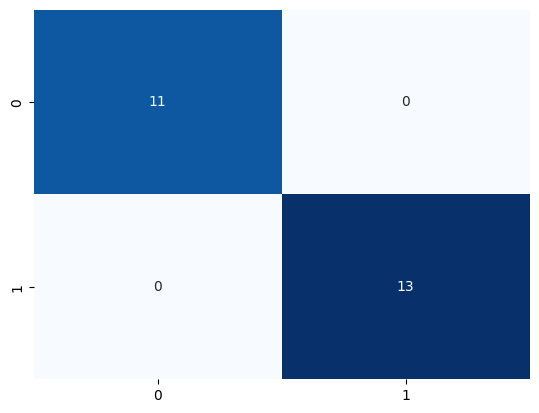

In [64]:
y_pred = IForest.predict(X_val)

y_pred_thresholded = (y_pred > 0).astype(int)
    
# Compute confusion matrix and normalize by true class labels
conf_matrix = confusion_matrix(y_val, y_pred_thresholded)#, normalize='true'
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False)
plt.show()

## Training Process Conclusion:

The training history of the CNN indicates the progression of the model's performance over multiple epochs. Here are key observations from the training process:

Loss and Accuracy Trends:

- The training process consists of 100 epochs, where each epoch represents a complete pass through the entire training dataset.
- Both training and validation datasets show a significant decrease in loss values over epochs, reaching very low values by the end.
- Accuracy values steadily increase, reaching a perfect accuracy of 1.0 on both training and validation datasets.

Overfitting Prevention:

- The training process employs the EarlyStopping callback with a patience of 10 epochs. This means that if there is no improvement in validation loss for 10 consecutive epochs, training will be stopped, and weights from the epoch with the best validation loss will be restored.
- EarlyStopping is effective in preventing overfitting, as indicated by the improvement in both training and validation accuracy without a decline in performance.

Model Convergence:

- The model shows convergence, as evidenced by the decreasing loss values and increasing accuracy.
- The validation accuracy reaches 1.0, indicating that the model generalizes well to unseen data.

# Reatime prediction

Real-time Prediction Using Trained CNN on Video File

Description:
This code demonstrates real-time prediction using a pre-trained Convolutional Neural Network (CNN) on a video file.
The OpenCV library is employed to read frames from the video, resize them, and display predictions based on a defined region.

Steps:
1. Replace 'your_video_file.mp4' with the actual path to your video file.
2. Open the video file using OpenCV.
3. Define the desired window dimensions for display.
4. Create a window with the specified dimensions.
5. Read each frame, resize it, and extract a region within a defined rectangle.
6. Preprocess the region, make predictions using the trained CNN model.
7. Update the rectangle color based on the prediction confidence.
8. Display the frame with the rectangle and prediction value.
9. Break the loop if the user presses 'q'.




In [71]:
aa = with_puck_img[0]/255.0
aa = feature_extractor.predict(np.expand_dims(aa,0))
pred = IForest.predict(aa)[0]

In [73]:
pred


1

In [ ]:

# Replace 'your_video_file.mp4' with the actual path to your video file
video_file_path = r'../videos_plateau_train_val/val.avi'

# Open the video file
cap = cv2.VideoCapture(video_file_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the original frame dimensions
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Set the desired window dimensions
# Note: Window resizing is necessary as my display resolution is not sufficient to show the entire video frame (2448x2048).
window_width = 800
window_height = int(window_width * (frame_height / frame_width))

# Create a window with the desired dimensions
cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Video', window_width, window_height)

# Define the coordinates of the rectangle
rect_start = (int(0.35 * window_width), int(0.5 * window_height))
rect_end = (int(0.55 * window_width), int(0.75 * window_height))

# Read and display the video frame by frame
while True:
    # Read a frame
    ret, frame = cap.read()

    # Resize the frame
    frame = cv2.resize(frame, (window_width, window_height))

    # Crop the region inside the rectangle
    cropped_region = frame[rect_start[1]:rect_end[1], rect_start[0]:rect_end[0]]

    # Preprocess the cropped region and make a prediction
    cropped_region = cv2.resize(cropped_region, (224, 224))
    cropped_region = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)/ 255.0  # Normalize pixel values
    cropped_region = feature_extractor.predict(np.expand_dims(cropped_region, axis=0))
    prediction = IForest.predict(cropped_region)[0]

    # Update the rectangle color based on the prediction
    if prediction > 0:
        rect_color = (0, 255, 0)  # Green rectangle for 0 output
    else:
        rect_color = (0, 0, 255)  # Red rectangle for 1 output

    # Draw the rectangle on the frame
    cv2.rectangle(frame, rect_start, rect_end, rect_color, 2)

    # Display the prediction value near the rectangle
    cv2.putText(frame, f'Prediction: {prediction:.4f}', (rect_start[0], rect_start[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Video', frame)

    # Break the loop if the user presses 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()


# Evaluation of the Model on Test set

To assess the trained model's performance, a fresh test dataset is formed using frames from the 'val.avi'. The model's evaluation involves the use of a confusion matrix and ROC curve.

In [ ]:
# Lists to store images and labels with puck
with_puck_img = []
label_with_puck_img = []

# Load images with puck and preprocess
for img in glob.glob("..\Test_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

# Lists to store images and labels without puck
without_puck_img = []
label_without_puck_img = []

# Load images without puck and preprocess
for img in glob.glob("..\Test_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

# Convert lists to NumPy arrays
with_puck_img = np.array(with_puck_img)
label_with_puck_img = np.array(label_with_puck_img)
without_puck_img = np.array(without_puck_img)
label_without_puck_img = np.array(label_without_puck_img)

# Display total number of images for each class
print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')

# Create the test dataset
X_test = np.concatenate((with_puck_img, without_puck_img), axis=0) / 255.0
y_test = np.concatenate((label_with_puck_img, label_without_puck_img), axis=0)

# Predictions on the test dataset
y_true = y_test
y_pred = model.predict(X_test)


Total number of puck images: 76
Total number of without puck images: 876


Class Imbalance:

- The test set has a significant class imbalance, with far more "without puck" images than "puck" images.
- This imbalance makes accuracy an unreliable metric as a model could achieve high accuracy by simply predicting the majority class.

Confusion Matrix with Varying Thresholds:

- Utilizing a confusion matrix with normalized cells at varying thresholds can provide a comprehensive view of the model's performance across different decision thresholds.
- It helps in understanding how the trade-off between precision and recall changes based on the threshold, which is crucial for decision-making.

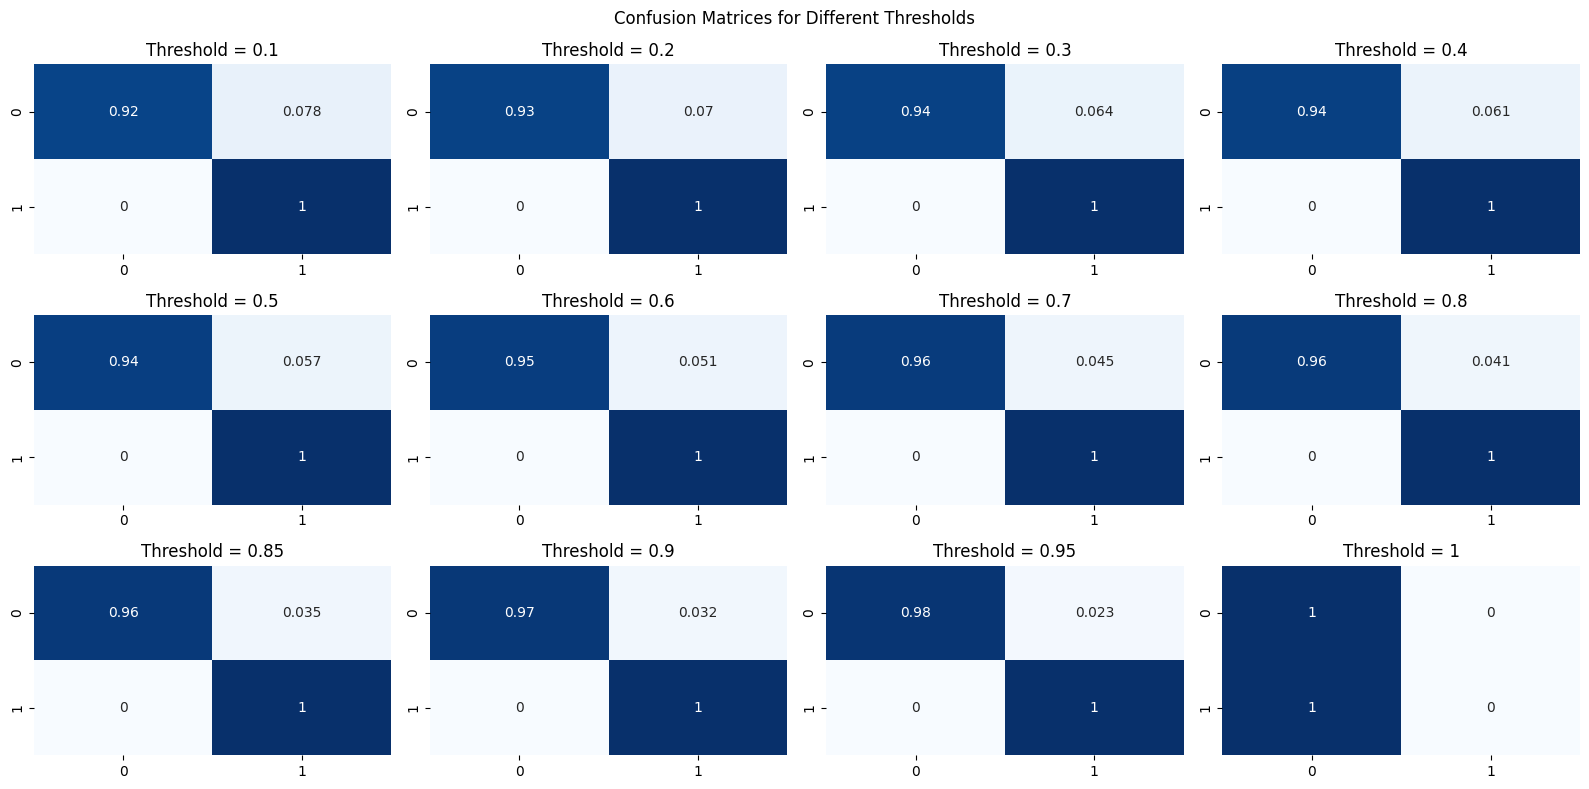

In [ ]:
# Compute confusion matrix for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
conf_matrices = []

# Iterate through each threshold
for threshold in thresholds:
    # Threshold predictions based on the current threshold value
    y_pred_thresholded = (y_pred > threshold).astype(int)
    
    # Compute confusion matrix and normalize by true class labels
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded, normalize='true')
    
    # Append the resulting confusion matrix to the list
    conf_matrices.append(conf_matrix)

# Plot confusion matrices
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
fig.suptitle('Confusion Matrices for Different Thresholds')

# Display each confusion matrix in a subplot
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(conf_matrices[i], annot=True, cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Threshold = {thresholds[i]}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


## Save the results of ROC as a pandas dataframe for later use

- AUC-ROC is valuable for binary classification tasks, especially when there is a class imbalance.
- It provides an aggregated measure of a model's ability to distinguish between classes across different thresholds.

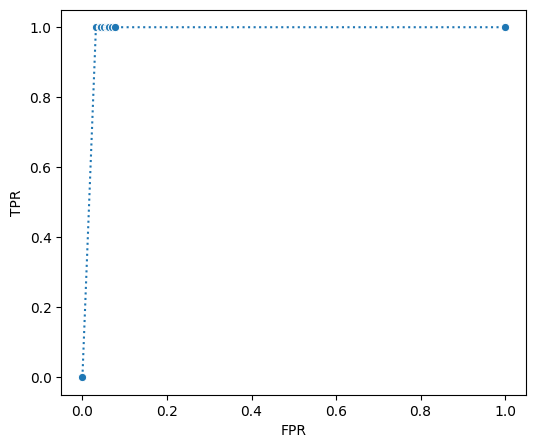

In [ ]:
# Define a list of thresholds for classification
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=('thresholds', 'TPR', 'FPR'))

# Loop through each threshold and calculate True Positive Rate (TPR) and False Positive Rate (FPR)
for idx, threshold in enumerate(thresholds):
    # Threshold the predicted probabilities
    y_pred_thresholded = (y_pred > threshold).astype(int)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded, normalize=None)
    TP, FP, TN, FN = conf_matrix[1, 1], conf_matrix[0, 1], conf_matrix[0, 0], conf_matrix[1, 0]
    
    # Calculate True Positive Rate (Sensitivity/Recall) and False Positive Rate
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    
    # Store results in the DataFrame
    results.loc[idx] = [threshold, TPR, FPR]

# Save results to a CSV file
results.to_csv('../ROC_curve_test_set/Baseline_model.csv', index=False)

# Plot ROC curve using Seaborn
plt.figure(figsize=(6,5))
sns.lineplot(data=results, x='FPR', y='TPR', marker='o', linestyle='dotted')
plt.show()

## Conclusion 

### After evaluating the model on various metric it can be said that a threshold value of 0.95 is best suited for this problem, which results in minimum FPR and highest TPR

# Model explainability using grad CAM

In [ ]:
from tensorflow.keras.models import Model

def Grad_CAM_heatmap(image_array):
    last_conv_layer = model.get_layer(index=-5)
    global_svg_pool_layer = model.get_layer(index=-3)
    intermediate_model = Model(model.inputs, [last_conv_layer.output,global_svg_pool_layer.output])

    last_cov,gap = intermediate_model(np.expand_dims(image_array,0))
    last_cov,gap = tf.squeeze(last_cov),tf.squeeze(gap)
    last_cov,gap = last_cov.numpy(),gap.numpy()

    for idx in range(last_cov.shape[-1]):
        last_cov[:,:,idx]=last_cov[:,:,idx]*gap[idx]

    heatmap = np.mean(last_cov, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

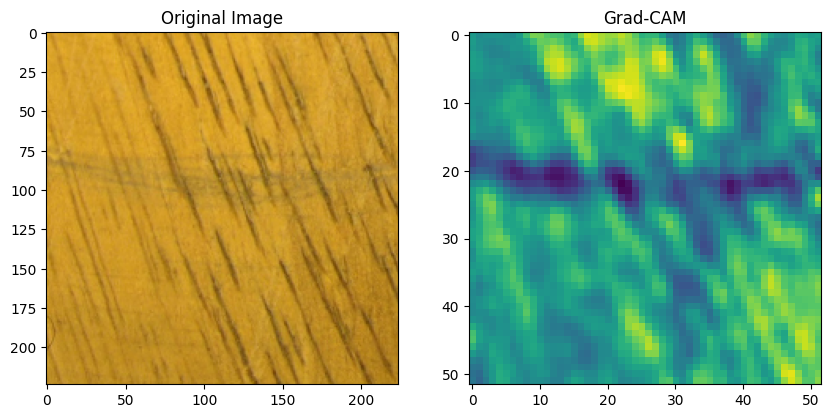

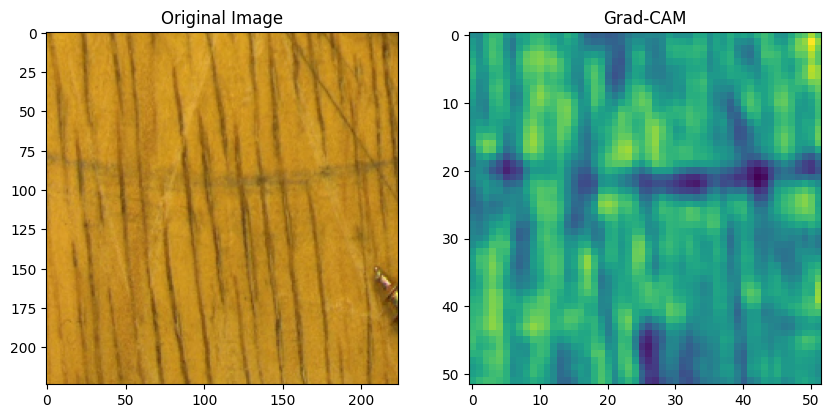

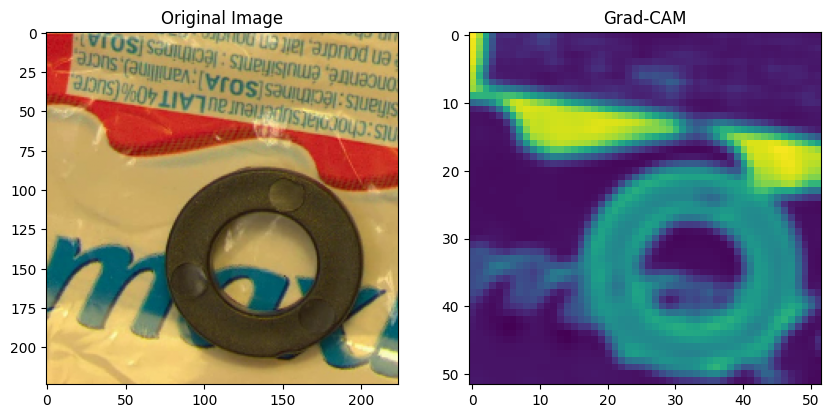

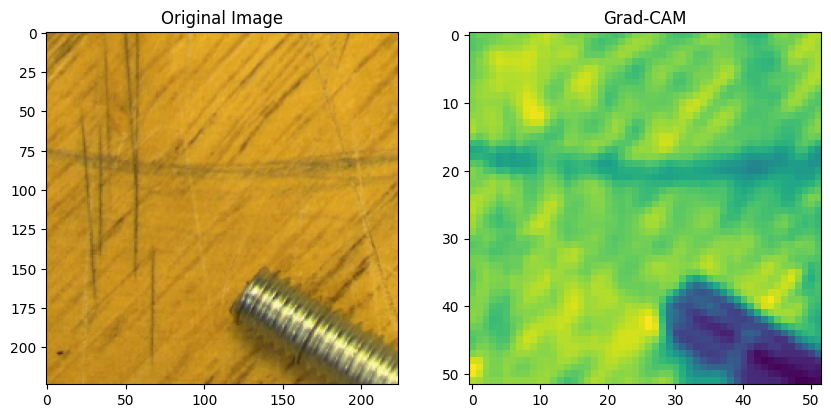

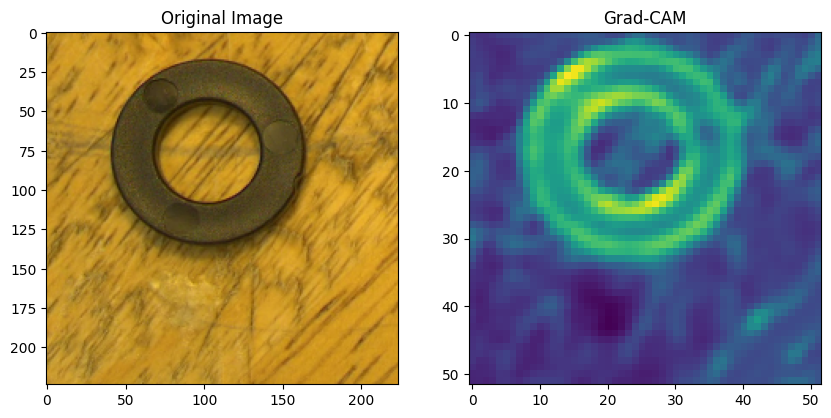

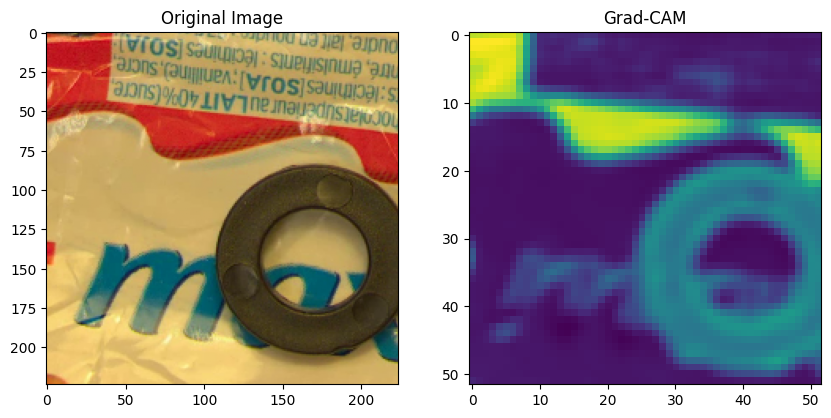

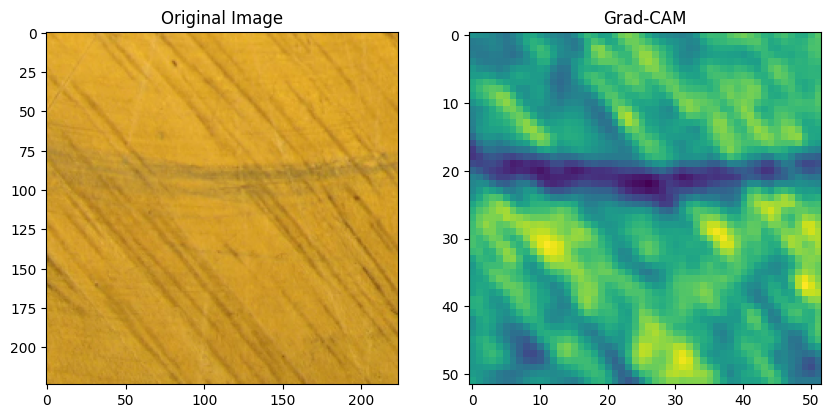

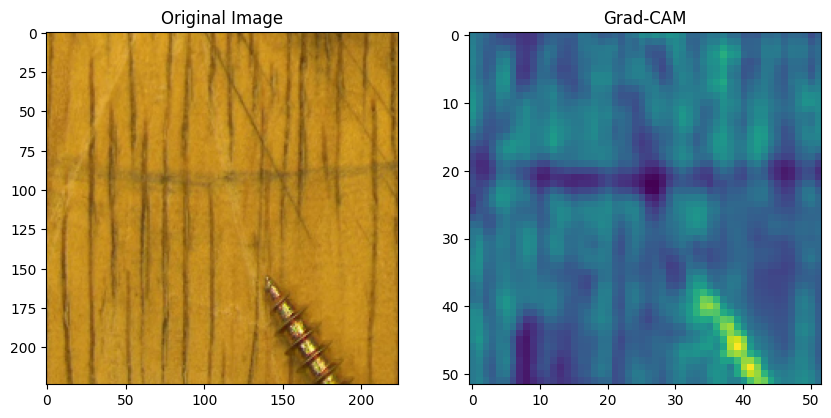

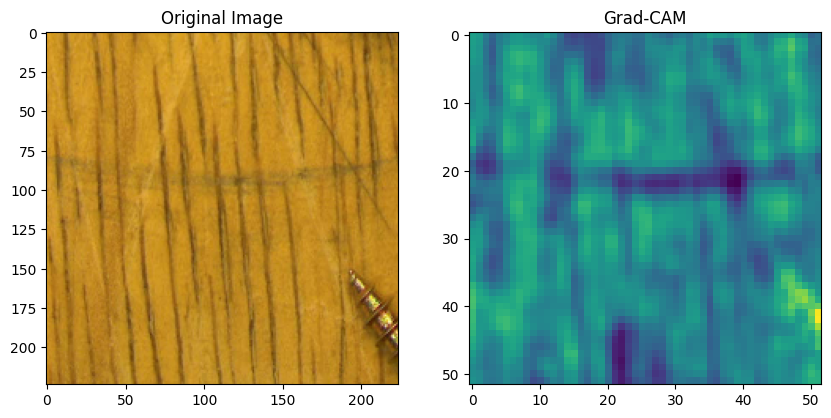

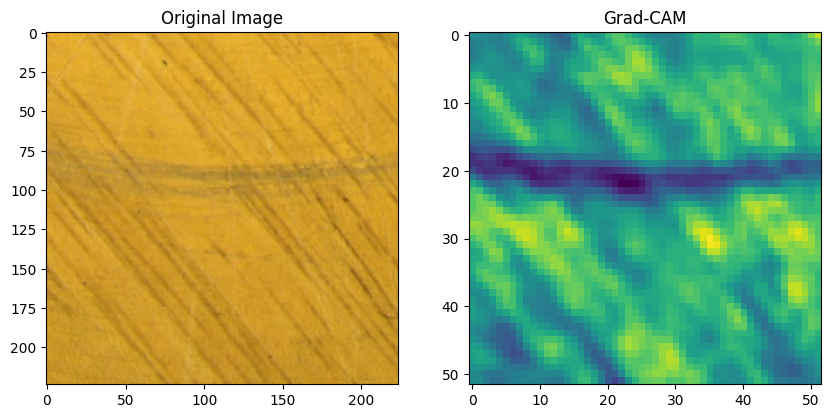

In [ ]:
for i in np.random.randint(0,400,10):

    img_test = X_test[i]
    heatmap = Grad_CAM_heatmap(img_test)
    # Display the original image and the superimposed image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_test)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM')
    plt.show()